# Lotka-Volterra system

In this example we present how to write a program to solve the Lotka-Volterra equations with Ponio.

The system is definied as:

$$
  \begin{aligned}
    \frac{\mathrm{d}x}{\mathrm{d}t} &= \alpha x  - \beta xy \\
    \frac{\mathrm{d}y}{\mathrm{d}t} &= \delta xy - \gamma y \\
  \end{aligned}
$$

where:

* $x$ is the number of prey
* $y$ is the number of predators
* $t$ represents time
* $\alpha$, $\beta$, $\gamma$ and $\delta$ are postive real parameters describing the interaction of the two species.

We would like to compute the invariant $V$ definied by:

$$
  V = \delta x - \gamma \ln(x) + \beta y - \alpha \ln(y)
$$

## Define the state

In Ponio is build to solve a problem defined as:

$$
  \dot{u}(t) = f(t,u(t))
$$

we defined as a state (or `state_t`) the type which represents $u$. In scalar problems, `state_t` is often `double`. In system problems, `state_t` has multiple composants and Ponio need to make some arithmetic operations on it, so it can be a [`std::valarray<double>`](https://en.cppreference.com/w/cpp/numeric/valarray) or [Eigen vector](https://eigen.tuxfamily.org/index.php?title=Main_Page), etc.

For Lotka-Volterra we have 2 composants so we will use in this example `std::valarray<double>`. We can defined this as:

```cpp
  using state_t = std::valarray<double>;
```

## Define problem

The [`ponio::solve`](#) function take as first argument a problem. In Ponio, a problem is a invokable object that take two arguments: $t$ the current time, and $u$ the current solution. So a problem can be:

* a simple function
* a lambda function
* a functor
* a [`ponio::problem`](#) (which need an invokable object)

A problem represents function $f$ in $\dot{u}=f(t,u)$ ODE. We would like to change easly  parameter so we will use a functor (a class that overload `()` operator):

```cpp
#include <valarray>

class Lotka_Volterra
{
    using state_t = std::valarray<double>;

    double alpha;
    double beta;
    double gamma;
    double delta;

    public:

    Lotka_Volterra(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}

    state_t
    operator() (double tn, state_t const& un)
    {
        double x = un[0], y = un[1];
        double dx = alpha*x - beta*x*y;
        double dy = delta*x*y - gamma*y;
        return {dx,dy};
    }
};
```

## Simple example

If we would like to save all iterations into a file we can use a `observer::file_observer`, if we would like to display all into `std::cout` we can use `observer::cout_observer`. In this example we print all into a file.

```cpp
int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    auto pb  = Lotka_Volterra(alpha,beta,gamma,delta);

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};

    ponio::solve(pb, ponio::runge_kutta::rk_44<>(), u_ini, {0.,tf}, dt, "lv_rk_44.dat"_fobs);

    return 0;
}
```

In [1]:
%system mkdir -p lotka_volterra_tuto_demo

[]

In [2]:
%%writefile lotka_volterra_tuto_demo/main_rk.cpp

#include <iostream>
#include <valarray>

#include "solver/solver.hpp"
#include "solver/observer.hpp"
#include "solver/runge_kutta.hpp"

class Lotka_Volterra
{
    using state_t = std::valarray<double>;

    double alpha;
    double beta;
    double gamma;
    double delta;

    public:

    Lotka_Volterra(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}

    state_t
    operator() (double tn, state_t const& un)
    {
        double x = un[0], y = un[1];
        double dx = alpha*x - beta*x*y;
        double dy = delta*x*y - gamma*y;
        return {dx,dy};
    }
};

int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    auto pb  = Lotka_Volterra(alpha,beta,gamma,delta);

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};

    ponio::solve(pb, ponio::runge_kutta::rk_44(), u_ini, {0.,tf}, dt, "lotka_volterra_tuto_demo/lv_rk.dat"_fobs);

    return 0;
}

Writing lotka_volterra_tuto_demo/main_rk.cpp


In [3]:
%system $CXX -std=c++20 -I ../include lotka_volterra_tuto_demo/main_rk.cpp -o lotka_volterra_tuto_demo/main_rk

[]

In [4]:
%system ./lotka_volterra_tuto_demo/main_rk

[]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = np.loadtxt("lotka_volterra_tuto_demo/lv_rk.dat")
t = data[:,0]
x = data[:,1]
y = data[:,2]

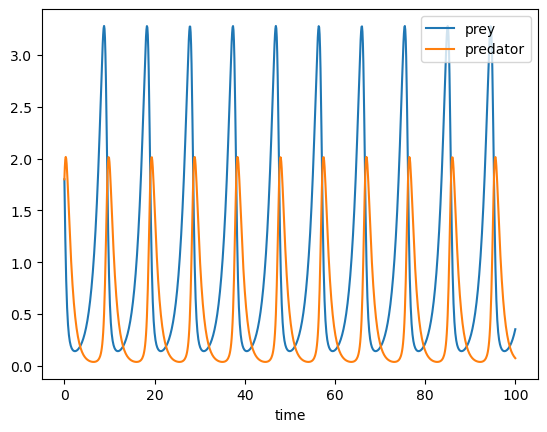

In [7]:
plt.plot(t,x,label="prey")
plt.plot(t,y,label="predator")
plt.xlabel("time")
plt.legend()
plt.show()

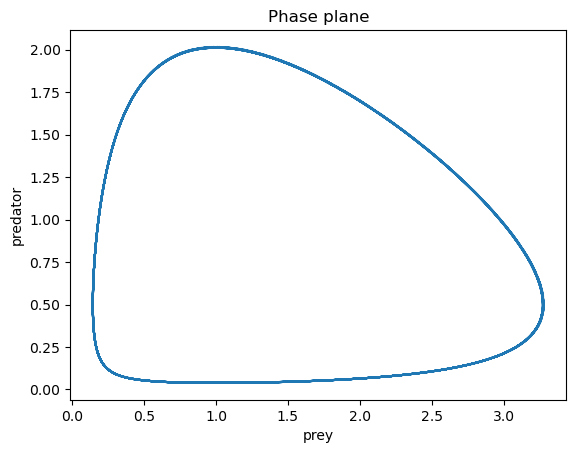

In [8]:
plt.plot(x,y)
plt.xlabel("prey")
plt.ylabel("predator")
plt.title("Phase plane")
plt.show()

Now define the invariant $V$ :
    
$$
  V = \delta x - \ln(x) + \beta y - \alpha \ln(y)
$$

In [9]:
def V(x,y, alpha=2./3., beta=4./3., gamma=1., delta=1.):
    return delta*x - np.log(x) + beta*y - alpha*np.log(y)

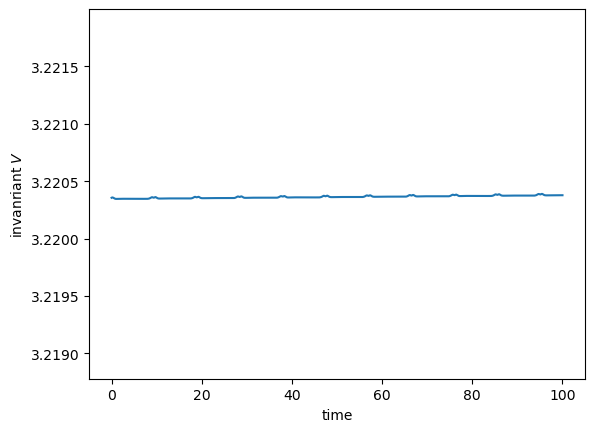

In [10]:
plt.plot(t,V(x,y))
plt.xlabel("time")
plt.ylabel("invanriant $V$")
vmax = max(V(x,y))
plt.ylim([(1-5e-4)*vmax,(1+5e-4)*vmax])
plt.show()

## Lawson method

Lawson methods are a class of time integration schemes that are applied to differential equations of the form:

$$
  \dot{u} = Lu + N(t,u), \qquad u(t=0) = u_0
$$

where $L$ is a matric and $N:(t,u)\mapsto N(t,u)$ is a, in general nonlinear, function of the unknow $u$, and the time $t\geq 0$. Lawson methods are especially efficient when applied to problems where $L$ implies a stringent stability condition if it is treated explicitly. Solving this equation with a Lawson method relies of the following change of variable:
$$
  v(t) := e^{-tL}u(t)
$$
Plugging this into our equation yields
$$
  \dot{v} = e^{-tL}N(t,e^{tL}v)
$$
Now an explicit Runge-Kutta method is applied to the transformed equation. We introduce the time discretization $t^n = n\Delta t$ with $\Delta t>0$ the time step, $n\in\mathbb{N}$ and $u^n$ (respectivement $v^n$) denotes the numerical approximation of $u(t^n)$ (resp. $v(t^n)$). For the sake of simplicity, we first present the method for the explicit Euler scheme. Applying the forward Euler method to this problem leads to

$$
  v(t^n+\Delta t)\approx v^{n+1} = v^n + \Delta t e^{-t^nL}N(t^n, e^{t^nL}v^n)
$$

Reversing the change of variable $u(t) = e^{tL}v(t)$ yields the following scheme for $u^n$

$$
  u(t^n+\Delta t)\approx u^{n+1} = e^{\Delta t L}u^n + \Delta t e^{\Delta tL}N(t^n, u^n)
$$

This is the Lawson-Euler method, also a method of order one. More generally, the Lawson method induced by an explicit Runge-Kutta method RK($s$,$p$) with $s$ stages of order $p$ can be written as:

$$
  \begin{aligned}
    k_i &= e^{-c_i\Delta t L}N(t^n + c_i\Delta t, e^{c_i\Delta tL}(u^n + \Delta t\sum_{j=1}^s
a_{ij}k_j)\\
    u^{n+1} &= e^{\Delta tL}(u^n + \Delta t\sum_{i=1}^s b_ik_i)
  \end{aligned}
$$

Here, we defined the following linear and non linear part:

$$
  L = \begin{pmatrix}
      \alpha & 0 \\
      0 & -\gamma
    \end{pmatrix}, \qquad
  N:(t,u)\mapsto \begin{pmatrix}
    -\beta xy \\
    \delta xy
  \end{pmatrix}
$$

Ponio doesn't provide a general exponential function, nor a matrix data structure, so we recommend to use [Eigen](https://eigen.tuxfamily.org). In this case linear part is diagonally so we can only use a `std::valarray<double>` as other examples.

To keep $L$ and $N$ in a same object, Ponio provide a `ponio::lawson_problem`:

```cpp
state_t L = {alpha, -gamma};
auto N = [=]( double t, state_t const& un ) -> state_t {
    double x = un[0], y = un[1];
    return { -beta*x*y, delta*x*y };
};

auto pb = ponio::make_lawson_problem(L, N);
```

This problem `pb` can be use as a `ponio::simple_problem` or `ponio::problem`. If we call `ponio::solve` with a `ponio::lawson_problem` and a Lawson algorithm (same name as Runge-Kutta algorithm but prefixed by `l`) Ponio applies a Lawson method to solve the problem. Calling a Lawson algorithm neeed to provide a exponential function, here we propose a solution with overloading of exponential function for `std::valarray`.

```cpp
auto exp = [](state_t const& x)->state_t { return std::exp(x); };
ponio::solve(pb, ponio::runge_kutta::lrk_44<>(exp), u_ini, {0.,tf}, dt, "lv_lrk.dat"_fobs);
```

In [11]:
%%writefile lotka_volterra_tuto_demo/main_lrk.cpp

#include <iostream>
#include <valarray>

#include "solver/solver.hpp"
#include "solver/observer.hpp"
#include "solver/problem.hpp"
#include "solver/runge_kutta.hpp"

int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    
    state_t L = { alpha, -gamma };
    auto N = [=]( double t, state_t const& u ) -> state_t {
        double x=u[0], y=u[1];
        return { -beta*x*y, delta*x*y };
    };
    auto pb  = ponio::make_lawson_problem(L,N);
    
    auto exp = [](state_t const& x)->state_t { return std::exp(x); };

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};

    ponio::solve(pb, ponio::runge_kutta::lrk_44(exp), u_ini, {0.,tf}, dt, "lotka_volterra_tuto_demo/lv_lrk.dat"_fobs);

    return 0;
}

Writing lotka_volterra_tuto_demo/main_lrk.cpp


In [12]:
%system $CXX -std=c++20 -I ../include lotka_volterra_tuto_demo/main_lrk.cpp -o lotka_volterra_tuto_demo/main_lrk

[]

In [13]:
%system ./lotka_volterra_tuto_demo/main_lrk

[]

In [14]:
data = np.loadtxt("lotka_volterra_tuto_demo/lv_lrk.dat")
t_lawson = data[:,0]
x_lawson = data[:,1]
y_lawson = data[:,2]

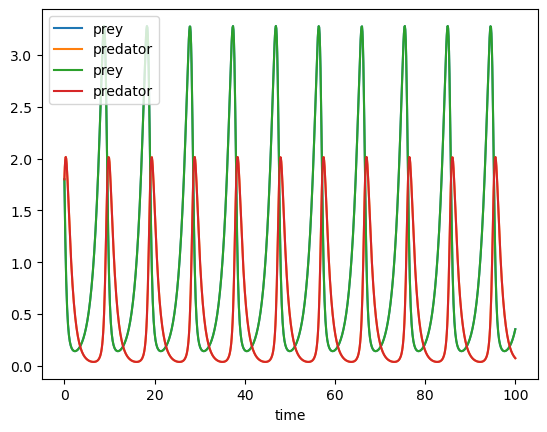

In [15]:
plt.plot(t,x,label="prey")
plt.plot(t,y,label="predator")
plt.plot(t_lawson,x_lawson,label="prey")
plt.plot(t_lawson,y_lawson,label="predator")
plt.xlabel("time")
plt.legend()
plt.show()

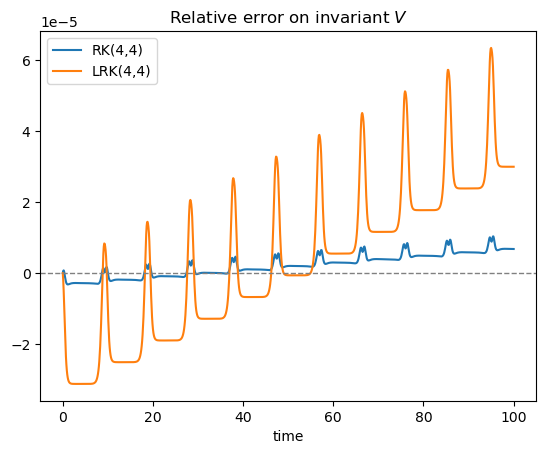

In [16]:
V0 = V(x[0],y[0])
plt.plot(t,V(x,y)/V0-1.,label="RK(4,4)")
plt.plot(t_lawson,V(x_lawson,y_lawson)/V0-1.,label="LRK(4,4)")
plt.axhline(0,t[0],t[-1],linestyle="--",color="grey",linewidth=1)
plt.title("Relative error on invariant $V$")
plt.xlabel("time")
plt.legend()
plt.show()

## Lie or Strang splitting method

An other class of time integrator in Ponio is splitting methods. To use it you need to define each subproblem. In Lotka-Volterra we chose to define this subproblems:

$$
  \varphi^{[1]} = \begin{cases}
    \dot{x} = \alpha x - \beta xy \\
    \dot{y} = 0
  \end{cases} , \qquad
  \varphi^{[2]} = \begin{cases}
    \dot{x} = 0 \\
    \dot{y} = \delta xy - \gamma y
  \end{cases}
$$

The Lie splitting is defined by

$$
  u^{n+1} = \varphi^{[1]}_{\Delta t} \circ \varphi^{[2]}_{\Delta t}(u^n)
$$
where $\varphi^{[i]}_{\Delta t}$ is a solution after time $\Delta t$ on the problem $\varphi^{[i]}$.

The Strang splitting method is defined by

$$
  u^{n+1} = \varphi^{[1]}_{\Delta t/2} \circ \varphi^{[2]}_{\Delta t} \circ \varphi^{[1]}_{\Delta t/2}(u^n)
$$

First we need to define two functions (or objects function):

```cpp
auto phi1 = [=]( double t, state_t const& u ) -> state_t {
    double x = u[0], y = u[1];
    return { alpha*x - beta*x*y , 0. };
};
auto phi2 = [=]( double t, state_t const& u ) -> state_t {
    double x = u[0], y = u[1];
    return { 0. , delta*x*y - gamma*y };
};
```

Now define a `ponio::problem` with `ponio::make_problem`

```cppr
auto pb = ponio::make_problem( phi1, phi2 );
```

To solve it with a Lie or Strang splitting method, we should define a tuple of methods to say how to solve each sub-problem and the time step for each sub-step:

```cpp
auto lie = ponio::splitting::make_lie_tuple(
                std::make_pair(ponio::runge_kutta::rk_44(),0.05),
                std::make_pair(ponio::runge_kutta::rk_33(),0.05)
           );

ponio::solve(pb, lie, u_ini, {0.,tf}, dt, "lv_lie.dat"_fobs);
```

For Strang splitting method, we define a `ponio::strang_tuple` in the same way

```cpp
auto strang = ponio::splitting::make_strang_tuple(
                std::make_pair(ponio::runge_kutta::rk_44(),0.05),
                std::make_pair(ponio::runge_kutta::rk_33(),0.05)
           );

ponio::solve(pb, strang, u_ini, {0.,tf}, dt, "lv_strang.dat"_fobs);
```

In [17]:
%%writefile lotka_volterra_tuto_demo/main_splitting.cpp

#include <iostream>
#include <valarray>

#include "solver/solver.hpp"
#include "solver/observer.hpp"
#include "solver/problem.hpp"
#include "solver/runge_kutta.hpp"
#include "solver/splitting.hpp"

int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    
    auto phi1 = [=]( double t, state_t const& u ) -> state_t {
        double x = u[0], y = u[1];
        return { alpha*x - beta*x*y , 0. };
    };
    auto phi2 = [=]( double t, state_t const& u ) -> state_t {
        double x = u[0], y = u[1];
        return { 0. , delta*x*y - gamma*y };
    };
    auto pb  = ponio::make_problem(phi1,phi2);

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};
    
    auto lie = ponio::splitting::make_lie_tuple(
        std::make_pair(ponio::runge_kutta::rk_44(),0.05),
        std::make_pair(ponio::runge_kutta::rk_33(),0.05)
    );
    auto strang = ponio::splitting::make_strang_tuple(
        std::make_pair(ponio::runge_kutta::rk_44(),0.05),
        std::make_pair(ponio::runge_kutta::rk_33(),0.05)
    );

    ponio::solve(pb, lie, u_ini, {0.,tf}, dt, "lotka_volterra_tuto_demo/lv_lie.dat"_fobs);
    ponio::solve(pb, strang, u_ini, {0.,tf}, dt, "lotka_volterra_tuto_demo/lv_strang.dat"_fobs);

    return 0;
}

Writing lotka_volterra_tuto_demo/main_splitting.cpp


In [18]:
%system $CXX -std=c++20 -I ../include lotka_volterra_tuto_demo/main_splitting.cpp -o lotka_volterra_tuto_demo/main_splitting

[]

In [19]:
%system ./lotka_volterra_tuto_demo/main_splitting

[]

In [20]:
data = np.loadtxt("lotka_volterra_tuto_demo/lv_lie.dat")
t_lie = data[:,0]
x_lie = data[:,1]
y_lie = data[:,2]

data = np.loadtxt("lotka_volterra_tuto_demo/lv_strang.dat")
t_strang = data[:,0]
x_strang = data[:,1]
y_strang = data[:,2]

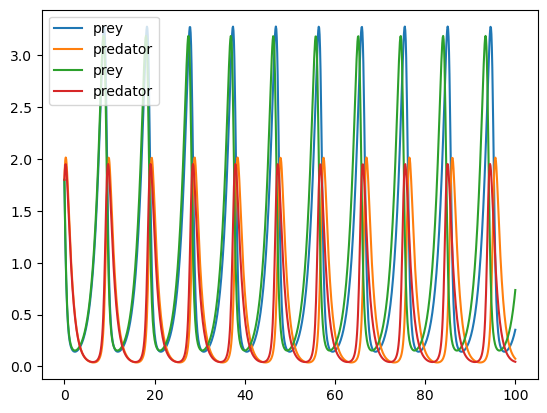

In [21]:
plt.plot(t,x,label="prey")
plt.plot(t,y,label="predator")
plt.plot(t_lie,x_lie,label="prey")
plt.plot(t_lie,y_lie,label="predator")
plt.legend()
plt.show()

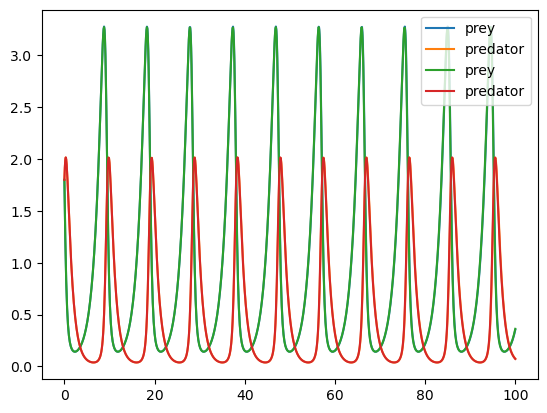

In [22]:
plt.plot(t,x,label="prey")
plt.plot(t,y,label="predator")
plt.plot(t_strang,x_strang,label="prey")
plt.plot(t_strang,y_strang,label="predator")
plt.legend()
plt.show()

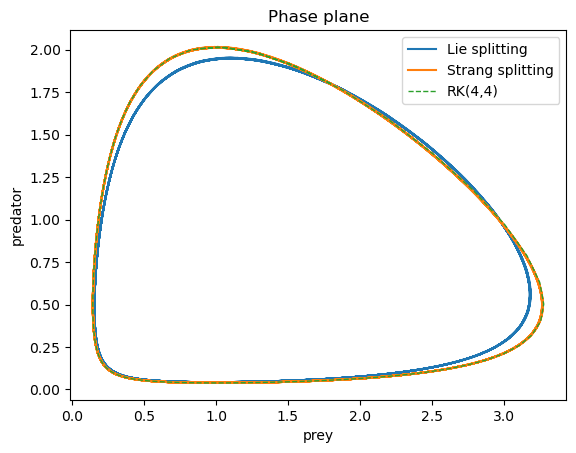

In [23]:
plt.plot(x_lie,y_lie,label="Lie splitting")
plt.plot(x_strang,y_strang,label="Strang splitting")
plt.plot(x[:int(len(x)/10)],y[:int(len(x)/10)],"--",linewidth=1,label="RK(4,4)")
plt.legend()
plt.xlabel("prey")
plt.ylabel("predator")
plt.title("Phase plane")
plt.show()

## Write your own observer

Ponio provides some observer, *i.e.* some classes or functions that take current time, current state and current time step and save it any where you want. To do it:

* [`observer::cout_observer`](#)
* [`observer::file_observer`](#)

But this observers save only $(t^n,u^n,\Delta t^n)$ the current state of simulation, we would like to solve $V^n$ the invariant at time $t^n$.

To do it we need a function or a functor that take `tn` the current time, `un` the current state, and `dt` the current time step. In this example we will save all data into some `std::vector<double>` and after we will save it into a file for more analysis.

```cpp
#include <fstream>
#include <vector>
#include <valarray>
#include <numeric>

struct LV_observer
{
    std::vector<double> times;
    std::vector<double> X;
    std::vector<double> Y;
    std::vector<double> V;

    double alpha;
    double beta;
    double gamma;
    double delta;

    LV_observer(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}

    double invariant_V(std::valarray<double> const& u)
    {
        double x=u[0], y=u[1];
        return delta*x - gamma*std::log(x) + beta*y - alpha*std::log(y);
    }

    // only this function will be use by ponio
    void operator() (double tn, std::valarray<double> const& un, double dt)
    {
        times.push_back(tn);
        X.push_back(un[0]);
        Y.push_back(un[1]);
        V.push_back(invariant_V(un));
    }

    void print(std::string filename)
    {
        std::ofstream out(filename);

        for (auto i=0; i<times.size(); ++i) {
            out << times[i] << " " << X[i] << " " << Y[i] << " " << V[i] << "\n";
        }
    }
};
```

In [24]:
%%writefile lotka_volterra_tuto_demo/main_obs.cpp

#include <iostream>
#include <fstream>
#include <iomanip>
#include <vector>
#include <valarray>
#include <numeric>

#include "solver/solver.hpp"
#include "solver/runge_kutta.hpp"

class Lotka_Volterra
{
    using state_t = std::valarray<double>;

    double alpha;
    double beta;
    double gamma;
    double delta;

    public:

    Lotka_Volterra(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}

    state_t
    operator() (double tn, state_t const& un)
    {
        double x = un[0], y = un[1];
        double dx = alpha*x - beta*x*y;
        double dy = delta*x*y - gamma*y;
        return {dx,dy};
    }
};

struct LV_observer
{
    std::vector<double> times;
    std::vector<double> X;
    std::vector<double> Y;
    std::vector<double> V;

    double alpha;
    double beta;
    double gamma;
    double delta;

    LV_observer(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}

    double invariant_V(std::valarray<double> const& u)
    {
        double x=u[0], y=u[1];
        return delta*x - gamma*std::log(x) + beta*y - alpha*std::log(y);
    }

    // only this function will be use by Ponio
    void operator() (double tn, std::valarray<double> const& un, double dt)
    {
        times.push_back(tn);
        X.push_back(un[0]);
        Y.push_back(un[1]);
        V.push_back(invariant_V(un));
    }

    void print(std::string filename)
    {
        std::ofstream out(filename);

        for (auto i=0; i<times.size(); ++i) {
            out << std::setprecision(15);
            out << times[i] << " " << X[i] << " " << Y[i] << " " << V[i] << "\n";
        }
    }
};

int main()
{
  using state_t = std::valarray<double>;

  double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
  auto pb  = Lotka_Volterra(alpha,beta,gamma,delta);
  auto obs = LV_observer(alpha,beta,gamma,delta);

  double dt = 0.1;
  double Tf = 100;
  state_t u_ini = {1.8,1.8};

  ponio::solve(pb, ponio::runge_kutta::rk_65(), u_ini, {0.,Tf}, dt, obs);

  obs.print("lotka_volterra_tuto_demo/lv_obs.dat");

  return 0;
}

Writing lotka_volterra_tuto_demo/main_obs.cpp


In [25]:
%system $CXX -std=c++20 -I ../include lotka_volterra_tuto_demo/main_obs.cpp -o lotka_volterra_tuto_demo/main_obs

[]

In [26]:
%system ./lotka_volterra_tuto_demo/main_obs

[]

In [27]:
data = np.loadtxt("lotka_volterra_tuto_demo/lv_obs.dat")
t_2 = data[:,0]
x_2 = data[:,1]
y_2 = data[:,2]
v_2 = data[:,3]

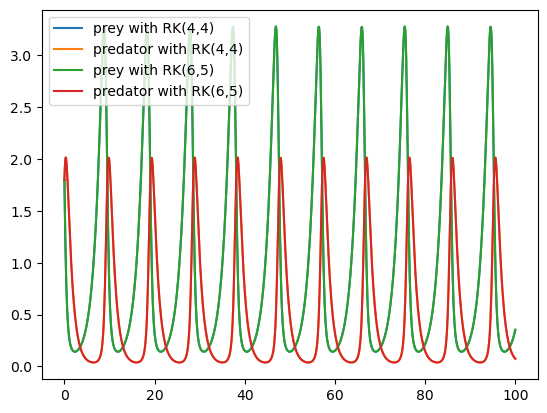

In [28]:
plt.plot(t,x,label="prey with RK(4,4)")
plt.plot(t,y,label="predator with RK(4,4)")
plt.plot(t_2,x_2,label="prey with RK(6,5)")
plt.plot(t_2,y_2,label="predator with RK(6,5)")
plt.legend()
plt.show()

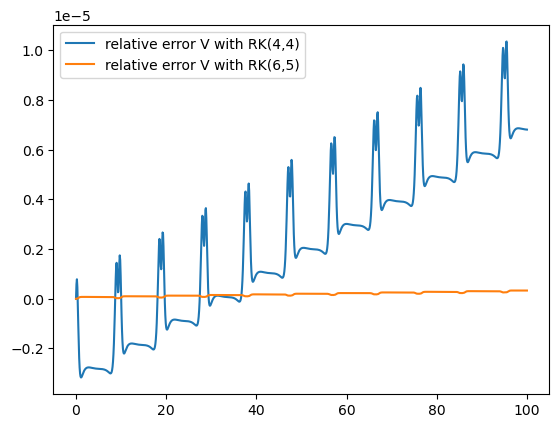

In [29]:
v = V(x,y)
plt.plot(t,(v-v[0])/v[0],label="relative error V with RK(4,4)")
plt.plot(t_2,(v_2-v_2[0])/v_2[0],label="relative error V with RK(6,5)")
plt.legend()
plt.show()